[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2p32dFTsjecDZOrOOJCok3qZuYV)

NOTE: it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits.

# Geneformer Cell Type Classification Benchmark
Here we benchmark four models, with two baselines. These models are tasked with cell type classification, using the Crohn's disease small intestine dataset from Elmentaite et al. (2020), Developmental Cell. This dataset contains approximately 22,500 single cells from both healthy children aged 4-13 and children with Crohn's disease. This dataset contains 31 unique cell types which we assume to be annotated accurately. This dataset was held out of our pre-training dataset as all diseased samples were removed.

* Baseline (1) scRNA workflow: this model uses PCA with 10 components and random forest on normalized and log transformed expression counts to produce a result.
* Baseline (2) geneformer with random weight initialization. Some performance can come from large random projections, but we want to do better than that.
* geneformer-10M + geneformer106M as described in the model cards.

First, we download the dataset from czi that we are interested in, and then create the requisite sc_memmap dataset object.

In [1]:
# NBVAL_CHECK_OUTPUT
import cellxgene_census


CENSUS_VERSION = "2023-12-15"
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(
        census,
        "Homo sapiens",
        obs_value_filter='dataset_id=="8e47ed12-c658-4252-b126-381df8d52a3d"',
    )
uq_cells = sorted(adata.obs["cell_type"].unique().tolist())
uq_cells

['B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'IgA plasma cell',
 'IgG plasma cell',
 'M cell of gut',
 'T follicular helper cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'conventional dendritic cell',
 'dendritic cell, human',
 'endothelial cell of artery',
 'endothelial cell of lymphatic vessel',
 'enterocyte',
 'enteroendocrine cell',
 'fibroblast',
 'gamma-delta T cell',
 'glial cell',
 'intestinal crypt stem cell',
 'intestinal tuft cell',
 'intestine goblet cell',
 'mast cell',
 'memory B cell',
 'monocyte',
 'myeloid cell',
 'myofibroblast cell',
 'pericyte',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'regulatory T cell',
 'transit amplifying cell',
 'vein endothelial cell']

In [2]:
# NBVAL_CHECK_OUTPUT
import random
from contextlib import contextmanager


@contextmanager
def random_seed(seed: int):
    """Context manager to set the random seed for reproducibility."""
    state = random.getstate()
    random.seed(seed)
    try:
        yield
    finally:
        # Go back to previous state
        random.setstate(state)


with random_seed(32):
    indices = list(range(len(adata)))
    random.shuffle(indices)

micro_batch_size: int = 32
num_steps: int = 256
# Subset the dataset to speedup the rest of hte pipeline.
adata = adata[:8000].copy()  # so it's not a view
adata.shape

(8000, 60664)

In [3]:
import shutil

from bionemo.core import BIONEMO_CACHE_DIR


cleanup: bool = True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_celltype_classification"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)
input_dir = notebook_workdir / "celltype-bench-dataset-input"
data_dir = notebook_workdir / "celltype-bench-dataset"
input_dir.mkdir(parents=True, exist_ok=True)
h5ad_outfile = input_dir / "hs-celltype-bench.h5ad"
adata.write_h5ad(h5ad_outfile)

## Create the scmemmap object, check outputs

In [4]:
!convert_h5ad_to_scdl --data-path {input_dir} --save-path {data_dir}

Importantly, the .npy files are used by BioNeMo dataset object. features.csv contains the metadata requested, in this case cell_type. It's important that the output of our model has the same order as features.csv, as this contains the labels used in the following benchmark.

In [5]:
# NBVAL_CHECK_OUTPUT
from glob import glob


files = sorted(
    [f.split("/")[-1] for f in glob(str(data_dir / "*"))]
)  # strip off the directory name and sort for the test
files

['col_ptr.npy',
 'data.npy',
 'features',
 'header.sch',
 'metadata.json',
 'row_ptr.npy',
 'version.json']

In [6]:
from bionemo.core.data.load import load


# 106m checkpoint
geneformer_106m = load("geneformer/106M_240530:2.0")
# 10m checkpoint
geneformer_10m = load("geneformer/10M_240530:2.0")
# 10m bionemo2 trained checkpoint
geneformer_10m_bnmo2 = load("geneformer/10M_241113:2.0")

Using cached path='/home/ubuntu/.cache/bionemo/7d67a526379eb8581f2aaaf03425ae9ec81a38570b24ddc8b22818e5d26ea772-geneformer_106M_240530_nemo2.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/7d67a526379eb8581f2aaaf03425ae9ec81a38570b24ddc8b22818e5d26ea772-geneformer_106M_240530_nemo2.tar.gz.checked')
Using cached path='/home/ubuntu/.cache/bionemo/a27061ee347f453b1bf175e288df31e9813903ebcb4924a77ac50dccc730889d-geneformer_10M_240530_nemo2.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/a27061ee347f453b1bf175e288df31e9813903ebcb4924a77ac50dccc730889d-geneformer_10M_240530_nemo2.tar.gz.checked')
Using cached path='/home/ubuntu/.cache/bionemo/fb6e70cd6bd98fb8941b5de978e95db17a6b8596f1c03f4d641a6d2ba6599757-geneformer_10M_241113_nemo2.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/fb6e70cd6bd98fb8941b5de978e95db17a6b8596f1c03f4d641a6d2ba6599757-geneformer_10M_241113_nemo2.tar.gz.checked')


In [7]:
result_path_10m = notebook_workdir / "results_10m.pt"
result_path_10m_bnmo2 = notebook_workdir / "results_10m_bnmo2.pt"
results_path_10m_random = notebook_workdir / "results_10m_randomweights.pt"
result_path_106m = notebook_workdir / "results_106m.pt"

## Execute inference
We run inference on all there of our models, which are downloaded by `load(...)` function in a previous cell. We have a one-off inference script for geneformer that is installed as part of the `bionemo-geneformer` package. See the `pyproject.toml` in the source directory if you are curious or want to use this as a template to make your own inference scripts. This script should work for any `sc_memmap` converted geneformer dataset, and geneformer bionemo2 model checkpoint though.

In [8]:
!infer_geneformer \
    --data-dir {data_dir} \
    --checkpoint-path {geneformer_10m} \
    --results-path {result_path_10m} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids

Using cached path='/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.checked')
[NeMo W 2025-09-16 20:19:49 nemo_logging:405] Tokenizer vocab file: /home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-09-16 20:19:49 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-09-16 20:19:49 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-09-16 20:19:49 nemo_loggi

In [9]:
!infer_geneformer \
    --data-dir {data_dir} \
    --results-path {results_path_10m_random} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048  \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids

Using cached path='/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.checked')
[NeMo W 2025-09-16 20:20:25 nemo_logging:405] Tokenizer vocab file: /home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-09-16 20:20:25 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-09-16 20:20:25 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-09-16 20:20:25 nemo_loggi

In [10]:
!infer_geneformer \
    --data-dir {data_dir} \
    --checkpoint-path {geneformer_106m} \
    --results-path {result_path_106m} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids

Using cached path='/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar' from checked=PosixPath('/home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.checked')
[NeMo W 2025-09-16 20:21:02 nemo_logging:405] Tokenizer vocab file: /home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-09-16 20:21:02 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-09-16 20:21:02 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-09-16 20:21:02 nemo_loggi

## Benchmarking
see below the benchmarking snippet. We take in a datavector, and a set of labels. We optionally fit PCA and then a RF model inside cross validation. Metrics are using the `macro` (average over each class) for handling multi-class labels. Additionally, we return the confusion matrix for further investigation.

In [11]:
import warnings

import numpy as np
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


def run_benchmark(data, labels, use_pca=True):
    """Run the accuracy, precision, recall, and F1-score benchmarks.

    Args:
        data: (R, C) contains the single cell expression (or whatever feature) in each row.
        labels: (R,) contains the string label for each cell
        use_pca: whether to fit PCA to the data.

    Returns:
        results_out: (dict) contains the accuracy, precision, recall, and F1-score for each class.
        conf_matrix: (R, R) contains the confusion matrix.
    """
    np.random.seed(1337)
    # Get input and output dimensions
    n_features = data.shape[1]
    hidden_size = 128

    # Define the target dimension 'n_components' for PCA
    n_components = min(10, n_features)  # ensure we don't try to get more components than features

    # Create a pipeline that includes scaling and MLPClassifier
    if use_pca:
        pipeline = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("projection", PCA(n_components=n_components)),
                (
                    "classifier",
                    MLPClassifier(
                        hidden_layer_sizes=(hidden_size,),
                        max_iter=500,
                        random_state=1337,
                        early_stopping=True,  # Enable early stopping
                        validation_fraction=0.1,  # Use 10% of training data for validation
                        n_iter_no_change=50,  # Stop if validation score doesn't improve for 10 iterations
                        verbose=False,  # Print convergence messages
                    ),
                ),
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "classifier",
                    MLPClassifier(
                        hidden_layer_sizes=(hidden_size,),
                        max_iter=500,
                        random_state=1337,
                        early_stopping=True,
                        validation_fraction=0.1,
                        n_iter_no_change=50,
                        verbose=False,
                    ),
                ),
            ]
        )

    # Set up StratifiedKFold to ensure each fold reflects the overall distribution of labels
    cv = StratifiedKFold(n_splits=5)

    # Define the scoring functions
    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="macro"),  # 'macro' averages over classes
        "recall": make_scorer(recall_score, average="macro"),
        "f1_score": make_scorer(f1_score, average="macro"),
    }

    # Track convergence warnings
    convergence_warnings = []
    with warnings.catch_warnings(record=True) as w:
        warnings.filterwarnings("always", category=ConvergenceWarning)

        # Perform stratified cross-validation with multiple metrics using the pipeline
        results = cross_validate(pipeline, data, labels, cv=cv, scoring=scoring, return_train_score=False)

        # Collect any convergence warnings
        convergence_warnings = [warn.message for warn in w if issubclass(warn.category, ConvergenceWarning)]

    # Print the cross-validation results
    print("Cross-validation metrics:")
    results_out = {}
    for metric, scores in results.items():
        if metric.startswith("test_"):
            results_out[metric] = (scores.mean(), scores.std())
            print(f"{metric[5:]}: {scores.mean():.3f} (+/- {scores.std():.3f})")

    predictions = cross_val_predict(pipeline, data, labels, cv=cv)

    # v Return confusion matrix and metrics.
    conf_matrix = confusion_matrix(labels, predictions)

    # Print convergence information
    if convergence_warnings:
        print("\nConvergence Warnings:")
        for warning in convergence_warnings:
            print(f"- {warning}")
    else:
        print("\nAll folds converged successfully")

    return results_out, conf_matrix

In [12]:
import torch


# TODO: enable model parallelism in predictions and modify paths accordingly.
infer_Xs_10m = torch.load(result_path_10m / "predictions__rank_0.pt")["embeddings"].float().cpu().numpy()
assert len(adata) == len(infer_Xs_10m), (len(adata), len(infer_Xs_10m))

In [13]:
!ls {result_path_10m}

predictions__rank_0.pt


In [14]:
infer_Xs_106m = torch.load(result_path_106m / "predictions__rank_0.pt")["embeddings"].float().cpu().numpy()
assert len(adata) == len(infer_Xs_106m), (len(adata), len(infer_Xs_106m))

In [15]:
infer_Xs_10m_random = (
    torch.load(results_path_10m_random / "predictions__rank_0.pt")["embeddings"].float().cpu().numpy()
)
assert len(adata) == len(infer_Xs_10m_random), (len(adata), len(infer_Xs_10m_random))

In [16]:
import pandas as pd


# Now fetch the class labels and raw expression for the same dataset. These are used as labels in classification and as one of our baselines.

infer_metadata = adata.obs
raw_Xs = np.asarray(adata.X.todense())
# Here we perform a norm over the total counts for each cell, adding a pseudocount to assist with the following logarithm.
normed_Xs = (raw_Xs + 1) / raw_Xs.sum(axis=1, keepdims=True)
logp1_Xs = np.log(normed_Xs)

/tmp/ipykernel_29376/11180894.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0.5, 1.0, 'Cell type counts for classification dataset')

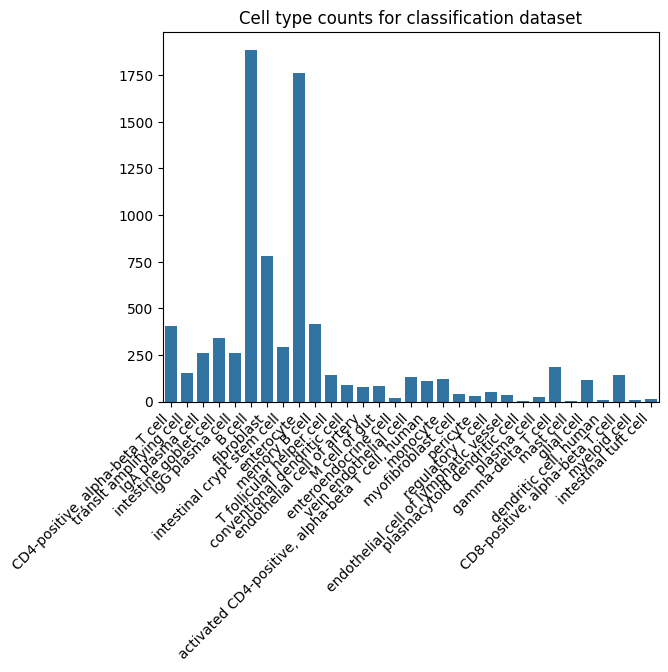

In [17]:
# Now we look at our dataset, how is the distribution of cell counts? Its clear that certain celltypes dominate the dataset, this is good to keep in mind when investigating models.
#  we expect the macro averages and F1-score to be the most reliable metrics for overall performance.
from collections import Counter

import seaborn as sb


labels = infer_metadata["cell_type"].values
label_counts = Counter(labels)

ax = sb.barplot(x=label_counts.keys(), y=label_counts.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Cell type counts for classification dataset")

In [18]:
# Now we assign integer labels to each of our strings. These do not need to be transformed into one-hot vectors as Random Forest is non-parametric.
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
print(integer_labels)

[ 1 29  1 ... 14 19 11]


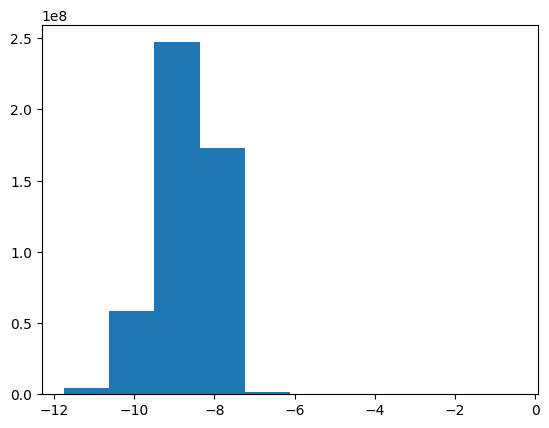

In [19]:
# Distribution of log transforms, looks decent.
from matplotlib import pyplot


pyplot.hist(logp1_Xs.flatten());

In [20]:
def plot_cm(cm, labels=label_encoder.classes_):
    """Helper function for visualizing accuracy across labels."""
    # # Example confusion matrix (replace with your actual data)
    # _ = np.random.rand(31, 31)

    # Define the bins and the color map
    # bounds = np.arange(0.0, 1.1, 0.1)
    # cmap = ListedColormap(sb.color_palette("RdYlBu_r", len(bounds) - 1))
    # norm = BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1, clip=True)

    # _ = sb.heatmap(cm / cm.sum(axis=0),cmap=cmap, norm=norm, cbar_kws={"ticks": bounds}, linewidths=0.5, linecolor='black', xticklabels=labels, yticklabels=labels)
    _ = sb.heatmap(
        cm / cm.sum(axis=0),
        cmap=sb.color_palette("Blues", as_cmap=True),
        vmin=0,
        vmax=1,
        linewidth=0.1,
        linecolor="lightgrey",
        xticklabels=labels,
        yticklabels=labels,
    )
    pyplot.xticks(rotation=45, ha="right")
    _ = pyplot.yticks(rotation=0)

## Execute benchmarks
Finally we execute our benchmarks, and collect results and confusion matrix. You can see in the figures below, we plot the performance by cell type for each model (confusion matrix heatmap). Perhaps unsurprisingly, we see that the most frequent cell type (enterocyte) has the highest accuracy across all models. This suggests bias in the model due to unbalanced data, however, further investigation is beyond the scope of this tutorial. Furthermore, we see continually improved performance as we move through the models, from baselines, to our provided pretrained model.

Perhaps most interesting is the 106M parameter model, which clearly outperforms all other models by all metrics, but especially by F1-score. This suggests that training larger models based on geneformer perform well, and that more work may be done.

In [21]:
logp1_results, logp1_cm = run_benchmark(logp1_Xs, integer_labels)

Cross-validation metrics:
accuracy: 0.778 (+/- 0.049)
precision: 0.591 (+/- 0.021)
recall: 0.558 (+/- 0.032)
f1_score: 0.544 (+/- 0.028)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



All folds converged successfully


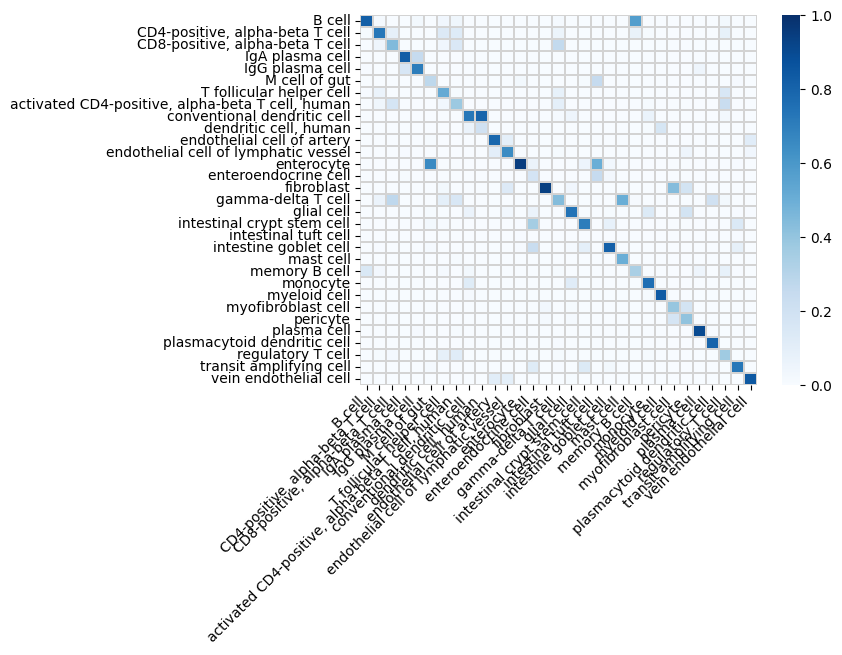

In [22]:
plot_cm(logp1_cm)

In [23]:
results_10m_random, cm_10m_random = run_benchmark(infer_Xs_10m_random, integer_labels, use_pca=False)

Cross-validation metrics:
accuracy: 0.630 (+/- 0.026)
precision: 0.312 (+/- 0.028)
recall: 0.268 (+/- 0.025)
f1_score: 0.275 (+/- 0.028)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



All folds converged successfully


/tmp/ipykernel_29376/2654938030.py:13: RuntimeWarning: invalid value encountered in divide
  cm / cm.sum(axis=0),


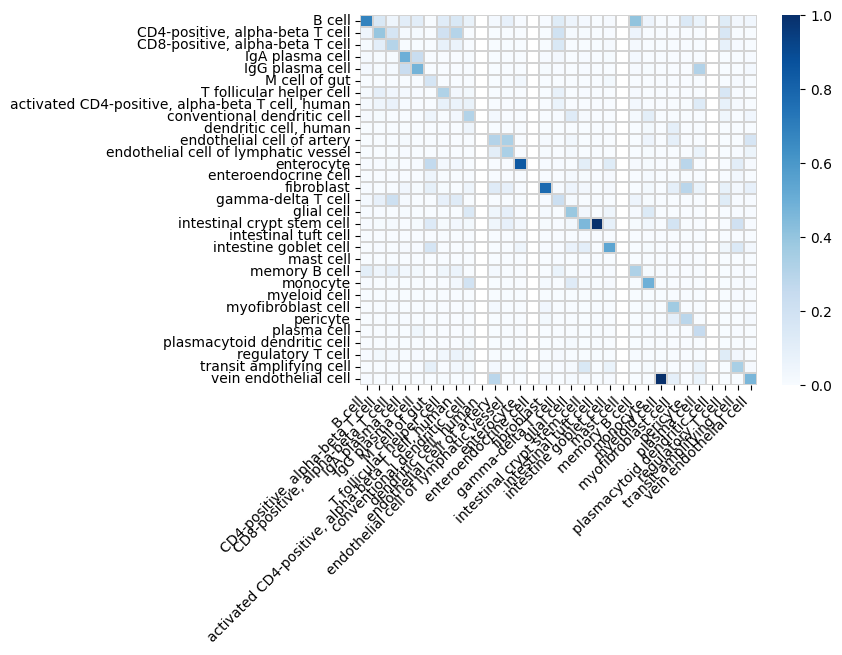

In [24]:
plot_cm(cm_10m_random)

In [25]:
results_10m, cm_10m = run_benchmark(infer_Xs_10m, integer_labels, use_pca=False)

Cross-validation metrics:
accuracy: 0.886 (+/- 0.026)
precision: 0.818 (+/- 0.051)
recall: 0.769 (+/- 0.028)
f1_score: 0.774 (+/- 0.041)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



All folds converged successfully


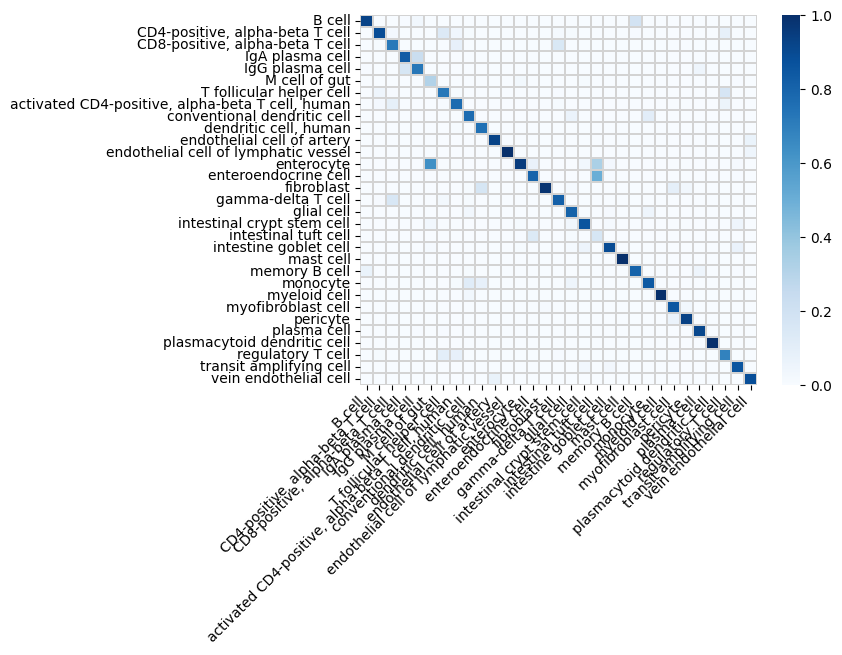

In [26]:
plot_cm(cm_10m)

In [27]:
results_106M, cm_106M = run_benchmark(infer_Xs_106m, integer_labels, use_pca=False)

Cross-validation metrics:
accuracy: 0.919 (+/- 0.034)
precision: 0.888 (+/- 0.041)
recall: 0.853 (+/- 0.030)
f1_score: 0.858 (+/- 0.037)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



All folds converged successfully


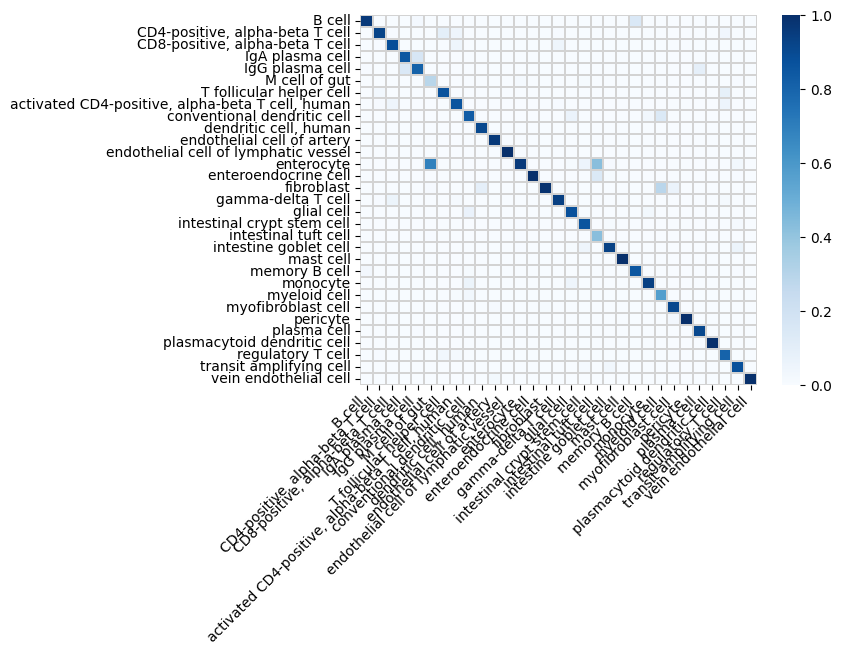

In [28]:
plot_cm(cm_106M)

/tmp/ipykernel_29376/1677600498.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x="model", y="f1_score_mean", data=df, capsize=0.2, palette="viridis", ax=ax)
/tmp/ipykernel_29376/1677600498.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x="model", y="accuracy_mean", data=df, ax=ax, capsize=0.2, palette="viridis")


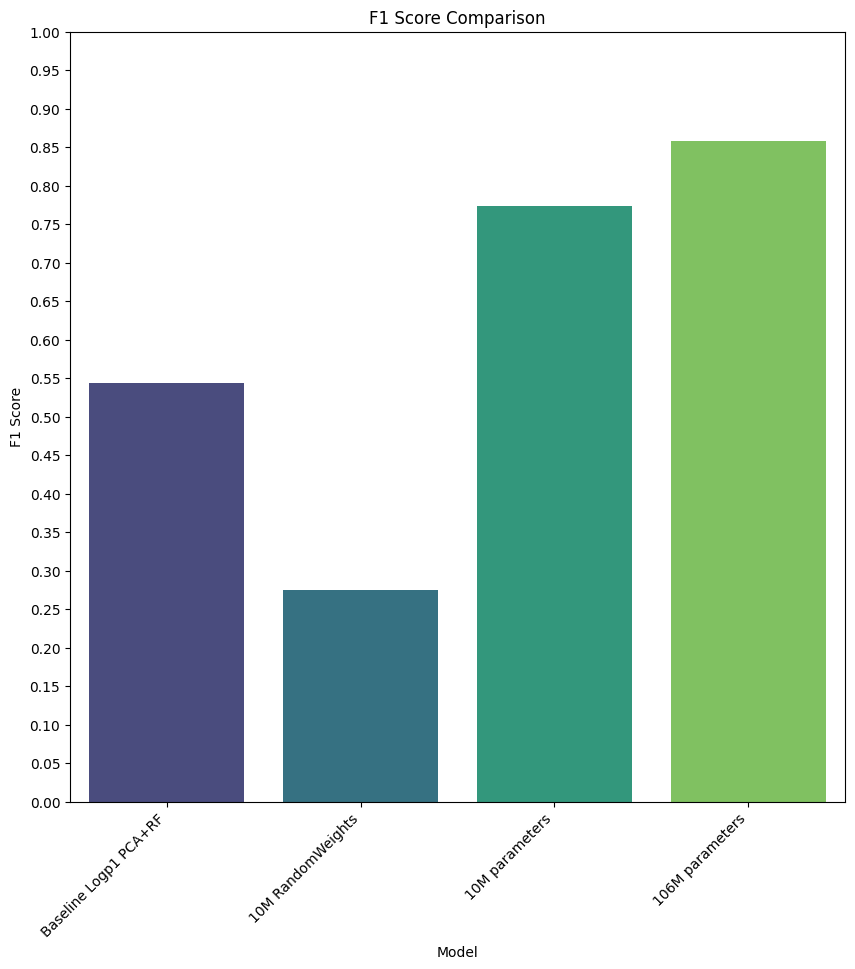

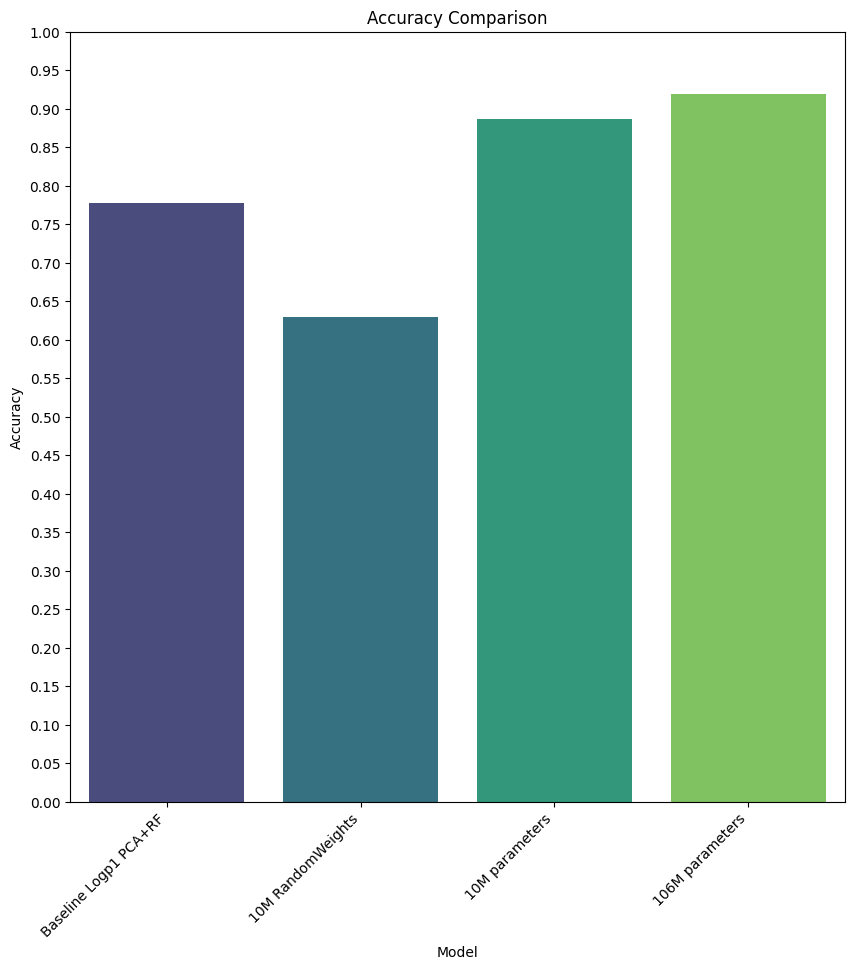

In [29]:
data = {
    "model": [
        "Baseline Logp1 PCA+RF",
        "10M RandomWeights",
        "10M parameters",
        # '10M parameters BioNeMo2 re-trained',
        "106M parameters",
    ],
    "f1_score_mean": [
        logp1_results["test_f1_score"][0],
        results_10m_random["test_f1_score"][0],
        results_10m["test_f1_score"][0],
        # results_10m_bnmo2['test_f1_score'][0],
        results_106M["test_f1_score"][0],
    ],
    "f1_score_std": [
        logp1_results["test_f1_score"][1],
        results_10m_random["test_f1_score"][1],
        results_10m["test_f1_score"][1],
        # results_10m_bnmo2['test_f1_score'][1],
        results_106M["test_f1_score"][1],
    ],
    "accuracy_mean": [
        logp1_results["test_accuracy"][0],
        results_10m_random["test_accuracy"][0],
        results_10m["test_accuracy"][0],
        # results_10m_bnmo2['test_accuracy'][0],
        results_106M["test_accuracy"][0],
    ],
    "accuracy_std": [
        logp1_results["test_accuracy"][1],
        results_10m_random["test_accuracy"][1],
        results_10m["test_accuracy"][1],
        # results_10m_bnmo2['test_accuracy'][1],
        results_106M["test_accuracy"][1],
    ],
}

df = pd.DataFrame(data)

fig, ax = pyplot.subplots(figsize=(10, 10))
# F1 Score plot
sb.barplot(x="model", y="f1_score_mean", data=df, capsize=0.2, palette="viridis", ax=ax)
ax.set_title("F1 Score Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("F1 Score")
ax.set_yticks(np.arange(0.0, 1.05, 0.05))
ax.set_ylim(0.0, 1.0)
pyplot.xticks(rotation=45, ha="right")
pyplot.savefig("F1-score-models.png")

# Accuracy plot
fig, ax = pyplot.subplots(figsize=(10, 10))
sb.barplot(x="model", y="accuracy_mean", data=df, ax=ax, capsize=0.2, palette="viridis")
ax.set_title("Accuracy Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_yticks(np.arange(0.0, 1.05, 0.05))
ax.set_ylim(0.0, 1.0)
pyplot.xticks(rotation=45, ha="right")
pyplot.savefig("average-accuracy-models.png")